In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime

In [2]:
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
data=pd.read_csv('data/Telefonia_movil.csv',parse_dates=True)
data.dtypes

Año                                    int64
Trimestre                              int64
Minutos pospago salientes (miles)     object
Minutos prepago salientes (miles)      int64
Total de minutos salientes (miles)     int64
Periodo                               object
dtype: object

In [4]:
data["Minutos pospago salientes (miles)"] = data["Minutos pospago salientes (miles)"].apply(lambda x: x.replace('.',''))
data["Minutos pospago salientes (miles)"] = data["Minutos pospago salientes (miles)"].astype(int)

In [5]:
data["Periodo"] = data["Año"].map(str) +'Q'+ data["Trimestre"].map(str)
index = pd.PeriodIndex(list(data.Periodo), freq='Q')
data.index = index
data['2017']

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
2017Q1,2017,1,14630269,6209983,20840252,2017Q1
2017Q2,2017,2,15315167,6293563,21608730,2017Q2
2017Q3,2017,3,15106275,6308373,21414647,2017Q3
2017Q4,2017,4,14164552,5380710,19545262,2017Q4


In [6]:
data.shape

(25, 6)

We will work with 2 series: Minutos pospago salientes y minutos prepago salientes

In [7]:
y1 = data["Minutos pospago salientes (miles)"]
y2 = data["Minutos prepago salientes (miles)"]

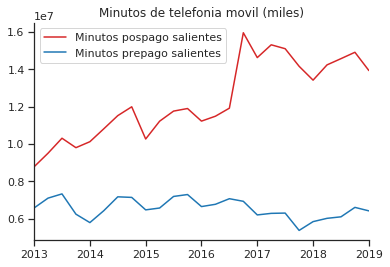

In [8]:
fig, ax= plt.subplots();#figsize=(9,6))
y1.plot(color=red,label = "Minutos pospago salientes")
y2.plot(color=blue,label = "Minutos prepago salientes")
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Minutos de telefonia movil (miles)')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
plt.legend()
sns.despine()
plt.show()

Lets do some more explorations! 
Apparently, both variables behave differently over time, so it would be good to analyze them
separately (and possibly applying different models to them).

In [9]:
data['Trimestre'] = data.index.quarter
data['Año'] = data.index.year

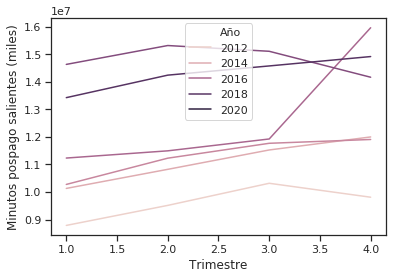

In [10]:
sns.lineplot('Trimestre','Minutos pospago salientes (miles)',hue='Año',data=data, markers='None');


Here we can notice that it has a clear growing tendency over the years.
Although there is not a clear seasonality, we can notice that it grows steadily in the
first trimesters, and then it gets kinda unpredictable.

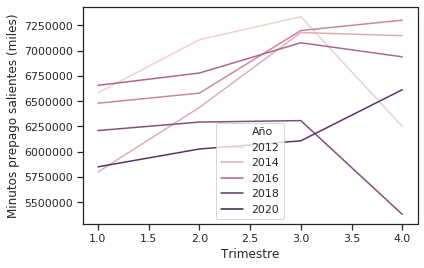

In [11]:
sns.lineplot('Trimestre','Minutos prepago salientes (miles)',hue='Año',data=data, markers='None');

Similar observations for this one, in the third and fourth quarter it gets unpredictable. sometimes grows, sometimes it goes down.

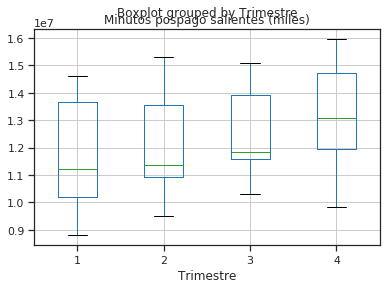

In [12]:
data.boxplot(column='Minutos pospago salientes (miles)',by='Trimestre');

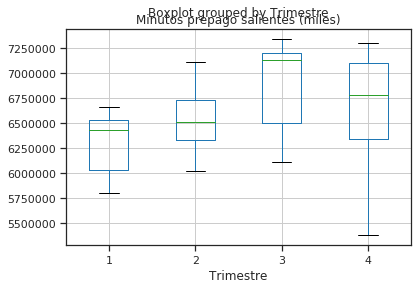

In [13]:
data.boxplot(column='Minutos prepago salientes (miles)',by='Trimestre');

Well, in both diagrams we can observe that the whiskers of the box plots in the fourth trimester
are wider, from 1st to 3rd the boxes are "growing".
Lets do some lag plots to see if we can predict some seasonality, maybe per quartile? The fourth will
fail obviously because it looks really unpredictable in both columns.

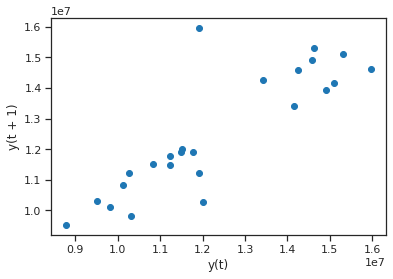

In [14]:
from pandas.plotting import lag_plot
lag_plot(data['Minutos pospago salientes (miles)'],lag=1);

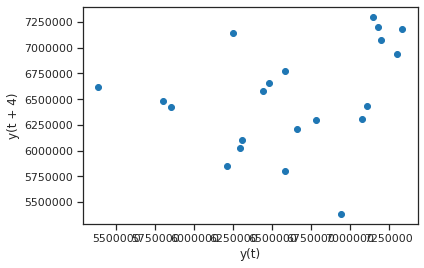

In [15]:
lag_plot(data['Minutos prepago salientes (miles)'],lag=4);

Well, that didn't work for many many values. So maybe, our data is bad and cant be predicted with a
naive model as random walk but we will do our best.

## Random walk

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts. 

1. Specify the forecast horizon.

2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series.  
If we had noticed any kind of seasonality in the data. it would be nice to put it here. As we didnt,
except for maybe minutos pospago saliente (with 1 the data grouped kinda well) we will work with the most regular data (y2)

In [16]:
y1 = data["Minutos pospago salientes (miles)"].astype(float)
y2 = data["Minutos prepago salientes (miles)"].astype(float)

In [17]:
h = 4
test=pd.period_range(start=y2.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y2.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred


2019Q2    6427084.0
2019Q3    6427084.0
2019Q4    6427084.0
2020Q1    6427084.0
Freq: Q-DEC, dtype: float64

To compute interval forecasts, we first estimate the standard deviation of the errors.

In [18]:
resid=y2-y2.shift(1)# the shift lags the series by one period
resid=resid[1:]
sigma = resid.std()
round(sigma,3)

510832.977

Using the formulas from the lecture, the interval forecasts are as below. 

In [19]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2019Q2,5425869.763,7428298.237
2019Q3,5011153.247,7843014.753
2019Q4,4692930.072,8161237.928
2020Q1,4424655.526,8429512.474


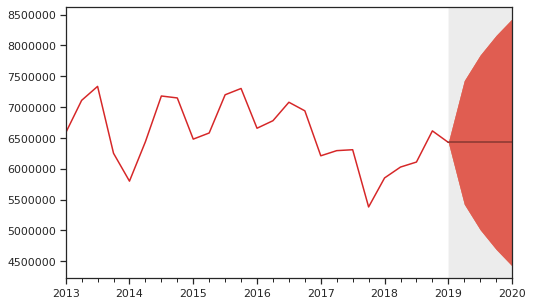

In [20]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2
fig1, ax1 = fanchart(y2,point_pred,intv,intv,intv)

plt.show()

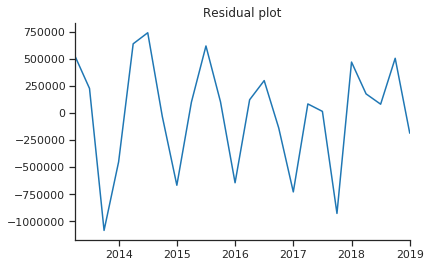

In [21]:
fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

In [22]:
def hist(series):
    fig, ax= plt.subplots();#figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return (fig, ax)

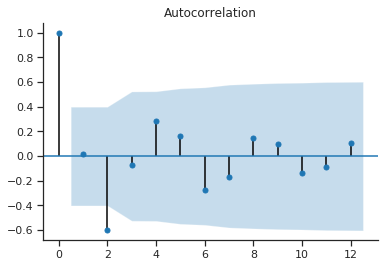

In [23]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=12, ax=ax)
sns.despine()
plt.show()

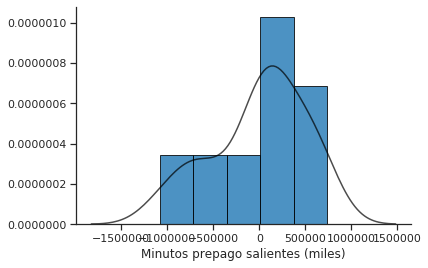

In [24]:
hist(resid)
plt.show()

In [25]:
validation=y2['2016Q3':].index # validación desde 2016 Q3 (40% de los datos)
start = y2.index.get_loc('2016Q3') # indice de 2017 Q1

pred1_1 = []
actual_1= []
for i in range(start, len(y2)):
    
    actual_1.append(y2.iloc[i]) # actual value
    
    pred1_1.append(y2.iloc[i-1]) # random walk forecast
    
columns=['RW', 'Actual']
results_sm_1 = np.vstack([pred1_1,actual_1]).T
results_sm_1 = pd.DataFrame(results_sm_1, columns=columns, index=validation)
results_sm_1

,RW,Actual
2016Q3,6778732.0,7077838.0
2016Q4,7077838.0,6938892.0
2017Q1,6938892.0,6209983.0
2017Q2,6209983.0,6293563.0
2017Q3,6293563.0,6308373.0
2017Q4,6308373.0,5380710.0
2018Q1,5380710.0,5850985.0
2018Q2,5850985.0,6027374.0
2018Q3,6027374.0,6108477.0
2018Q4,6108477.0,6613685.0


These are kinda good metrics.  
Something good is that we cannot observe any kind of patterns in the residue.

In [26]:
from scipy import stats

table_1 = pd.DataFrame(0.0, index=results_sm_1.columns[:-1], columns=['RMSE','SE'])
for i in range(1):
    table_1.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm_1.iloc[:,i], results_sm_1.iloc[:,-1])
    table_1.iloc[i,1] = (results_sm_1.iloc[:,i] - results_sm_1.iloc[:,-1]).sem()

In [27]:
print("Random Walk for prepago")
display(table_1.round(3))

Random Walk for prepago


,RMSE,SE
RW,432408.343,136365.326


### Simple exponential smoothing

Lets try some simple exponential smoothing!  
This might works better since our data has not a really good seasonality  
We will try this for y1.

In [28]:
model_ses = sm.tsa.SimpleExpSmoothing(y1).fit()
fitted_ses = model_ses.fittedvalues
model_ses.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,28393933896676.352
Optimized:,True,AIC,697.958
Trend:,None,BIC,700.396
Seasonal:,None,AICC,699.958
Seasonal Periods:,None,Date:,"Thu, 31 Oct 2019"
Box-Cox:,False,Time:,11:29:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7870587,alpha,True
initial_level,8.7859e+06,l.0,True


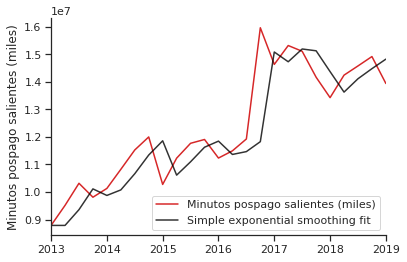

In [29]:
fig, ax= plt.subplots();#figsize=(9,6))
y1.plot(color=red, label='Minutos pospago salientes (miles)')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos pospago salientes (miles)')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

Well that looks really fine, this data that doesnt have a clear seasonality was ideal for
exponential smoothing


In [30]:
resid_ses=y1-fitted_ses
resid_ses = resid_ses[1:]

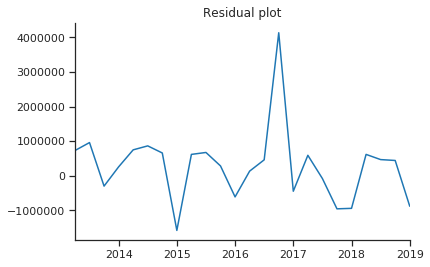

In [31]:
fig, ax= plt.subplots();#figsize=(9,6))
resid_ses.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

It is good that our residue doesnt have any visible tendencies.

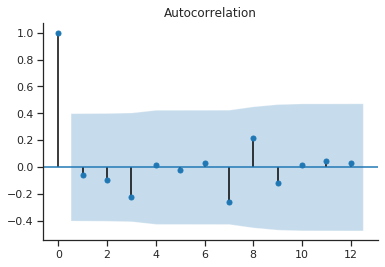

In [32]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid_ses, lags=12, ax=ax)
sns.despine()
plt.show()

Here, we can also observe that our residue is low and doesnt follow any particular pattern

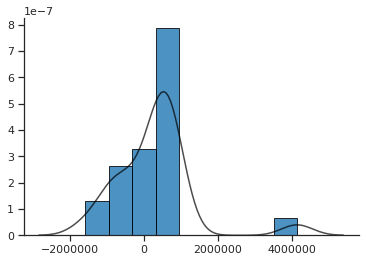

In [33]:
hist(resid_ses)
plt.show()

Not normally distributed residue, and the peak is because it is not predicting
correctly the peak nearly 2017. We can observe that in the other residue plot.

In [34]:
validation=y1['2016Q3':].index # validación desde 2016 Q3 (40% de los datos)
start = y1.index.get_loc('2016Q3') # indice de 2017 Q1

pred1_2 = []
actual_2= []
for i in range(start, len(y1)):
    
    actual_2.append(y1.iloc[i]) # actual value
    
    model = sm.tsa.SimpleExpSmoothing(y1.iloc[:i]).fit() 
    pred1_2.append(model.forecast(1)[0]) # SES forecast
    
columns=['SES', 'Actual']
results_sm_1 = np.vstack([pred1_2,actual_2]).T
results_sm_1 = pd.DataFrame(results_sm_1, columns=columns, index=validation)
results_sm_1

,SES,Actual
2016Q3,1.146548e+07,11923391.0
2016Q4,1.178916e+07,15960765.0
2017Q1,1.596076e+07,14630269.0
2017Q2,1.471815e+07,15315167.0
2017Q3,1.518988e+07,15106275.0
2017Q4,1.512393e+07,14164552.0
2018Q1,1.437147e+07,13423580.0
2018Q2,1.359029e+07,14240217.0
2018Q3,1.411031e+07,14574305.0
2018Q4,1.448080e+07,14915060.0


In [36]:
table_1 = pd.DataFrame(0.0, index=results_sm_1.columns[:-1], columns=['RMSE','SE'])
for i in range(1):
    table_1.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm_1.iloc[:,i], results_sm_1.iloc[:,-1])
    table_1.iloc[i,1] = (results_sm_1.iloc[:,i] - results_sm_1.iloc[:,-1]).sem()

print("Simple exponential Smooth for pospago")
display(table_1.round(3))

Simple exponential Smooth for pospago


,RMSE,SE
SES,1451825.917,453162.579


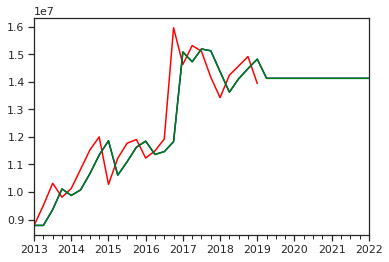

In [35]:
h=12
w=h*10
data = y1
model = sm.tsa.SimpleExpSmoothing
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');